# Setup

Install needed libraries

In [3]:
# !pip install pandas
# !pip install youtube_dl
# !pip install sklearn
# !pip install bs4
# !pip install requests
# !pip install label-studio
# !pip install matplotlib
# !pip install scipy
# !pip install lightgbm
!pip install scikit-optimize

In [4]:
!label-studio

^C


In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import youtube_dl
import matplotlib.pyplot as plt
from matplotlib import pylab
import ast
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
import requests as rq
import joblib as jb
import bs4 as bs4
import json

# Getting the data

In [7]:
queries = ["machine+learning", "valorant", "investimentos", "investiments", "data+science", "italian"]

In [ ]:
ydl = youtube_dl.YoutubeDL({'ignoreerrors': True})
resultados = []
for query in queries:
    r = ydl.extract_info("ytsearch2000:{}".format(query), download=False)
    for entry in r['entries']:
        if entry is not None:
            entry['query'] = query
    resultados += r['entries']

In [16]:
resultados = [e for e in resultados if e != None]

In [17]:
df = pd.DataFrame(resultados)
df['upload_date'] = pd.to_datetime(df["upload_date"])
df["days_since_upload"] = (pd.to_datetime("2022-02-10") - df["upload_date"])/np.timedelta64(1, 'D')
df.head()

,id,title,formats,thumbnails,description,upload_date,uploader,uploader_id,uploader_url,channel_id,...,album,url,manifest_url,tbr,protocol,preference,http_headers,release_date,release_year,days_since_upload
0,JyGGMyR3x5I,Machine Learning: Tutorial prático usando apen...,"[{'asr': 48000, 'filesize': 16323674, 'format_...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",✅ALURA COM 10% DE DESCONTO: https://www.alura....,2019-11-08,Filipe Deschamps,UCU5JicSrEM5A63jkJ2QvGYw,http://www.youtube.com/channel/UCU5JicSrEM5A63...,UCU5JicSrEM5A63jkJ2QvGYw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,825.0
1,0PrOA2JK6GQ,Machine Learning Explicado,"[{'asr': 48000, 'filesize': 5203175, 'format_i...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",Machine learning (ou aprendizado de máquina) é...,2021-02-25,Ciência Todo Dia,CienciaTodoDia,http://www.youtube.com/user/CienciaTodoDia,UCn9Erjy00mpnWeLnRqhsA1g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,350.0
2,t5z5lyrb-7s,Introdução ao Machine Learning (ML de Zero a 1...,"[{'asr': 48000, 'filesize': 2603732, 'format_i...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",This video is also available in English: https...,2019-11-13,TensorFlow,UC0rqucBdTuFTjJiefW5t-IQ,http://www.youtube.com/channel/UC0rqucBdTuFTjJ...,UC0rqucBdTuFTjJiefW5t-IQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,820.0
3,5q87K1WaoFI,Computer Scientist Explains Machine Learning i...,"[{'asr': 48000, 'filesize': 9863039, 'format_i...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",WIRED has challenged computer scientist and Hi...,2021-08-18,WIRED,wired,http://www.youtube.com/user/wired,UCftwRNsjfRo08xYE31tkiyw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176.0
4,qDmojpkd8rE,O que é Machine Learning (Aprendizado de Máqui...,"[{'format_id': '139', 'manifest_url': 'https:/...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",Nesse vídeo vamos aprender o que é machine lea...,2019-06-21,Didática Tech,UC0BiVs5EYh57gzGVvhddjsA,http://www.youtube.com/channel/UC0BiVs5EYh57gz...,UC0BiVs5EYh57gzGVvhddjsA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,965.0


In [18]:
df["thumbnails_links"] = df["thumbnails"].apply(lambda x: ast.literal_eval(x)[-1]['url'])

In [19]:
columns = ['id', 'title', 'upload_date', 'query', 'view_count', 'thumbnails_links', 'description', 'uploader', 'days_since_upload']
df.to_csv(".\\csv\\raw_data.csv", index=False)
df[columns].to_csv(".\\csv\\raw_data_filtered.csv", index=False)

# Processing the data

In [49]:
df_labeled = pd.read_csv("csv\\raw_data_labeled.csv")
def y(x):
    if x == "É interessante":
        return 1
    if x == "Não é interessante":
        return 0
    return np.nan
df_labeled["y"] = df_labeled["intent"].apply(lambda x: y(x))
df_labeled = df_labeled.drop(["created_at", "updated_at", "lead_time", "annotation_id", "annotator", "intent"], axis=1)
df_labeled.head()

,id,title,upload_date,query,view_count,thumbnails_links,description,uploader,days_since_upload,y
0,704,Building Machine Learning models with Edge Imp...,2021-11-11,machine+learning,2265150,https://i.ytimg.com/vi/gw1E5JZTim0/hqdefault.j...,Meet Jan Jongboom (CTO) and Jenny Plunkett (En...,TensorFlow,91.0,1.0
1,679,Che differenza c'è tra Intelligenza Artificial...,2016-11-04,machine+learning,34731,https://i.ytimg.com/vi_webp/EGqdZsKOa4M/maxres...,Che differenza c'è tra Intelligenza Artificial...,Ciao Internet - Matteo Flora,1924.0,0.0
2,765,Signal Processing and Machine Learning,2015-07-15,machine+learning,106799,https://i.ytimg.com/vi/mexN6d8QF9o/hqdefault.j...,Learn about Signal Processing and Machine Lear...,IEEE Signal Processing Society,2402.0,0.0
3,1064,TSM vs Girl Kissers - HIGHLIGHTS | Champions T...,2022-01-27,valorant,163671,https://i.ytimg.com/vi/uM2USjJHnXA/maxresdefau...,#tsm #tsmvsGK #GK\n►Stats: https://www.vlr.gg/...,Daily Valorant,14.0,0.0
4,595,Machine Learning Tutorial Python - 16: Hyper p...,2019-11-23,machine+learning,125419,https://i.ytimg.com/vi_webp/HdlDYng8g9s/maxres...,In this python machine learning tutorial for b...,codebasics,810.0,1.0


In [50]:
df = pd.read_csv("csv\\raw_data.csv")
df.head()

,id,title,formats,thumbnails,description,upload_date,uploader,uploader_id,uploader_url,channel_id,...,url,manifest_url,tbr,protocol,preference,http_headers,release_date,release_year,days_since_upload,thumbnails_links
0,JyGGMyR3x5I,Machine Learning: Tutorial prático usando apen...,"[{'asr': 48000, 'filesize': 16323674, 'format_...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",✅ALURA COM 10% DE DESCONTO: https://www.alura....,2019-11-08,Filipe Deschamps,UCU5JicSrEM5A63jkJ2QvGYw,http://www.youtube.com/channel/UCU5JicSrEM5A63...,UCU5JicSrEM5A63jkJ2QvGYw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,825.0,https://i.ytimg.com/vi_webp/JyGGMyR3x5I/maxres...
1,0PrOA2JK6GQ,Machine Learning Explicado,"[{'asr': 48000, 'filesize': 5203175, 'format_i...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",Machine learning (ou aprendizado de máquina) é...,2021-02-25,Ciência Todo Dia,CienciaTodoDia,http://www.youtube.com/user/CienciaTodoDia,UCn9Erjy00mpnWeLnRqhsA1g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,350.0,https://i.ytimg.com/vi/0PrOA2JK6GQ/maxresdefau...
2,t5z5lyrb-7s,Introdução ao Machine Learning (ML de Zero a 1...,"[{'asr': 48000, 'filesize': 2603732, 'format_i...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",This video is also available in English: https...,2019-11-13,TensorFlow,UC0rqucBdTuFTjJiefW5t-IQ,http://www.youtube.com/channel/UC0rqucBdTuFTjJ...,UC0rqucBdTuFTjJiefW5t-IQ,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,820.0,https://i.ytimg.com/vi_webp/t5z5lyrb-7s/maxres...
3,5q87K1WaoFI,Computer Scientist Explains Machine Learning i...,"[{'asr': 48000, 'filesize': 9863039, 'format_i...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",WIRED has challenged computer scientist and Hi...,2021-08-18,WIRED,wired,http://www.youtube.com/user/wired,UCftwRNsjfRo08xYE31tkiyw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176.0,https://i.ytimg.com/vi/5q87K1WaoFI/maxresdefau...
4,qDmojpkd8rE,O que é Machine Learning (Aprendizado de Máqui...,"[{'format_id': '139', 'manifest_url': 'https:/...","[{'height': 94, 'url': 'https://i.ytimg.com/vi...",Nesse vídeo vamos aprender o que é machine lea...,2019-06-21,Didática Tech,UC0BiVs5EYh57gzGVvhddjsA,http://www.youtube.com/channel/UC0BiVs5EYh57gz...,UC0BiVs5EYh57gzGVvhddjsA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,965.0,https://i.ytimg.com/vi_webp/qDmojpkd8rE/maxres...


In [51]:
def mapper_y(x):
    y = df_labeled.loc[df_labeled["thumbnails_links"] == x, "y"].tolist()
    if len(y) != 0:
        return y[0]
    return np.nan

df["y"] = df["thumbnails_links"].apply(lambda x: mapper_y(x))
df["views_per_day"] = df["view_count"]/df["days_since_upload"]   

In [52]:
df.to_csv("csv\\raw_data_labeled_ready.csv", index=False)

In [40]:
df = df[df["y"].notnull()]
df.shape

(518, 75)

# Split train test

<AxesSubplot:>

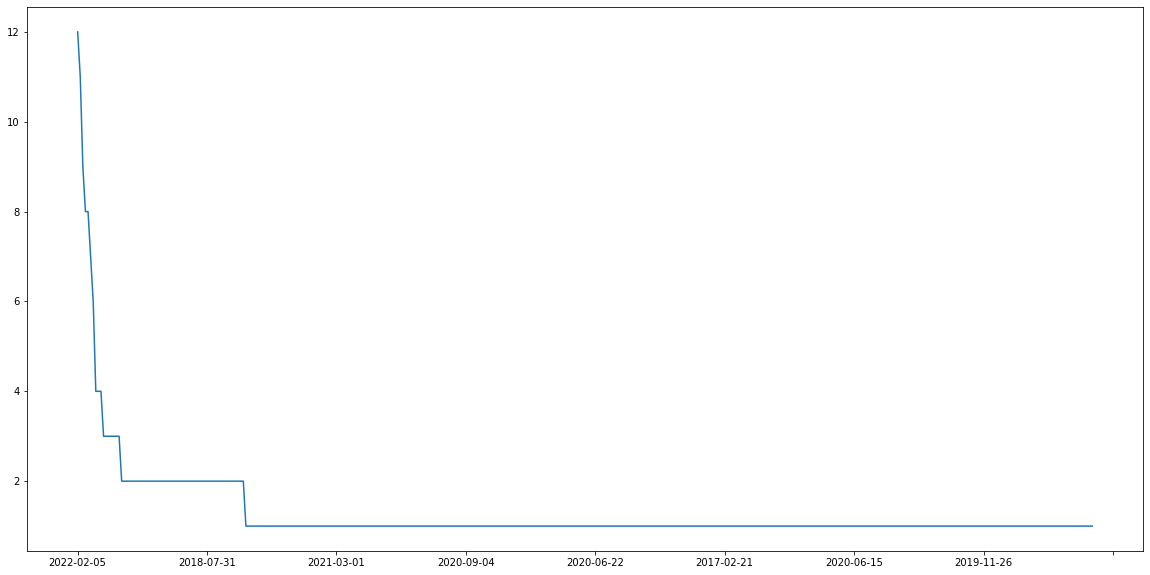

In [41]:
df["upload_date"].value_counts().plot(figsize=(20,10))

In [42]:
date = "2020-10-05"
Xtrain, Xval = df[df["upload_date"] < date].drop("y", axis=1), df[df["upload_date"] >= date].drop("y", axis=1)
ytrain, yval = df[df["upload_date"] < date]["y"], df[df["upload_date"] >= date]["y"]
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((263, 74), (255, 74), (263,), (255,))

# testing models

In [43]:
mdl = DecisionTreeClassifier(random_state=0, max_depth=2, class_weight="balanced")
mdl.fit(Xtrain[["view_count", "views_per_day"]], ytrain)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, random_state=0)

In [44]:
p = mdl.predict_proba(Xval[["view_count", "views_per_day"]])[:, 1]

In [45]:
average_precision_score(yval, p)

0.184948752228164

In [46]:
roc_auc_score(yval, p)

0.5387323943661972

[Text(0.5, 0.8333333333333334, 'view_count <= 394637.5\ngini = 0.5\nsamples = 263\nvalue = [131.5, 131.5]'),
 Text(0.25, 0.5, 'view_count <= 133020.0\ngini = 0.484\nsamples = 210\nvalue = [109.202, 75.712]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.499\nsamples = 155\nvalue = [78.328, 71.727]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.202\nsamples = 55\nvalue = [30.874, 3.985]'),
 Text(0.75, 0.5, 'view_count <= 2745884.0\ngini = 0.408\nsamples = 53\nvalue = [22.298, 55.788]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.47\nsamples = 47\nvalue = [21.726, 35.864]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.054\nsamples = 6\nvalue = [0.572, 19.924]')]

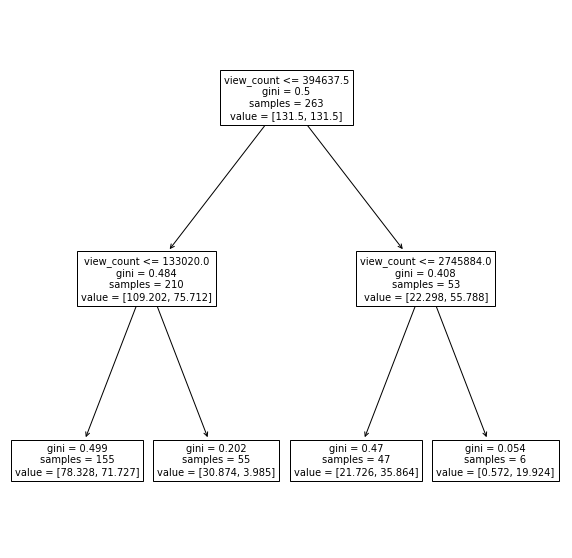

In [48]:
fig, ax = pylab.subplots(1, 1, figsize=(10, 10))
plot_tree(mdl, ax=ax, feature_names=Xtrain[["view_count", "views_per_day"]].columns)